<center><img src="https://is1-ssl.mzstatic.com/image/thumb/Purple122/v4/05/e7/67/05e76784-3364-b535-7e20-b3f4946a56b6/AppIcon-0-0-1x_U007emarketing-0-0-0-7-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/434x0w.webp" style="height:150px"></center>

<hr style="border-width:2px;border-color:red">
<center><h1>Test Technique Data Scientist</h1></center>
<center><h2> Mesure de la dérive </h2></center>
<hr style="border-width:2px;border-color:red">

# Contexte

La **dérive** en apprentissage automatique (ou **"drift"** en anglais) fait référence à un **changement dans les données d'entrée ou de sortie d'un modèle** de machine learning **après son entraînement initial**. Cela peut se produire lorsque les données utilisées pour entraîner le modèle ne **reflètent plus la réalité**, ou lorsque **les conditions du problème changent de manière significative**.

La dérive des données peut affecter la précision du modèle de manière significative et peut entraîner des erreurs coûteuses dans les prévisions ou les décisions basées sur le modèle. Par conséquent, **il est important de surveiller régulièrement les performances du modèle** et de le mettre à jour en fonction des nouveaux jeux de données ou des nouvelles conditions du problème.

# Objectif

Dans ce test, vous allez implémenter des métriques permettant de mesurer la dérive d'un modèle dans un usecase de **e-commerce** où nous essayons de prédire le **panier total** (variable **`TotalCart`** : chiffre d'affaire total d'un client sur la période donnée) des clients en fonction des variables suivantes:
* **`Age`** : âge du client en années.
* **`Seniority`** : ancienneté du client en années.
* **`Orders`** : Nombre de commandes effectuées sur la période précédente.
* **`Items`** : Nombre d'items commandés sur la période précédente.
* **`AverageDiscount`** : Réduction moyenne accordée au client sur la période précédente en pourcentage.
* **`TopCategory`** : Catégorie de produits favorite du client.
* **`BrowsingTime`** : Temps total passé sur le site web sur la période précédente en secondes.
* **`EmailsOpened`** : Nombre de mails marketing ouverts par le client sur la période précédente.
* **`SupportInteractions`** : Nombre d'interactions que le client a eu avec le service client sur la période précédente.

Le jeu de données est décomposé en 4 périodes correspondant aux 4 trimestres de l'année 2022. Vous trouverez les données correspondant à chaque période dans les fichiers **`period_0.csv`**, **`period_1.csv`**, ..., **`period_3.csv`**.

Vous allez d'abord **entraîner et évaluer un modèle de machine learning** sur les données de la **période 0**. On supposera que ce modèle sera utilisé pour effectuer les prédictions de panier total sur toute l'année 2022.

Ensuite, vous devrez **implémenter des métriques de dérive** qui vous seront données et **effectuer une analyse** de celle-ci.

# Entraînement du modèle

* **Entraînez et validez** deux ou trois modèles de votre choix sur les données de la période 0. 

**Conseils**

* Vous serez évalué sur votre **rigueur** et non sur les performances du modèle.


* Il n'est pas nécessaire de faire une analyse exploratoire des données.


* Il n'est pas nécessaire de faire de recherche d'hyperparamètres optimaux non plus mais vous pouvez le faire si vous le souhaitez.

### Préambule:
On se propose d'utiliser 2 modèles: d'abord une regression Ridge, la plus commune dans un cas comme celui-ci,
puis une régression par k-nearest-neighbors: un peu plus exotique (KNN est plus utilisée en classification).

In [1]:
# Insérez votre code ici

from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

df = pd.DataFrame(pd.read_csv("period_0.csv"))
#On vérifie le type des données de variables explicatives: présence de variable catégorielle
print("Type des variables explicatives:\n",df.dtypes)
#get_dummies rajoute une variable explicative pour chaque valeur de "TopCategory"
X = pd.get_dummies(data=df, drop_first=True)
#Création de la matrice de design du modèle X et du vecteur des réponses y
X = X.drop(columns="TotalCart", axis=1)
y = df["TotalCart"]
#Séparation du dataset en données d'entraînement et données de validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11111)
#--------------Régression Ridge--------------------------------------------
#On choisit l'hyperparamètre qui va maximiser le coefficient de détermination R^2 et on fit ce modèle
alphas = np.logspace(0, 5, 100)
ridge_model = lm.RidgeCV(alphas=alphas, scoring='r2').fit(X_train, y_train)
alpha_opt = ridge_model.alpha_
print(f"\nL'hyperparamètre optimal choisi est: alpha_Ridge = {alpha_opt:.2f}")
print("Le coefficient R^2 du modèle test est: ", ridge_model.score(X=X_train, y=y_train))
print("Le coefficient R^2 du modèle d'entraînement est: ", ridge_model.score(X=X_test, y=y_test))
#Validation du modèle
print(f"En d'autres termes, notre modèle validé explique {100*ridge_model.score(X=X_test, y=y_test):.2f}%  de la variance présente dans les données de test")
#Graphes des résidus de la régression vs quelques covariables choisies
for i, col in enumerate(np.transpose(X_test.values)):
    if X_test.columns[i] in {"AverageDiscount", "BrowsingTime", "Age"}:
        plt.figure()
        plt.plot(col, np.abs(ridge_model.predict(X_test)-y_test), ".")
        plt.title("Graphique des résidus de la régression VS.\n la covariable "+X_test.columns[i])
print("La MSE du prédicteur linéaire choisir est :", mean_squared_error(y_test, ridge_model.predict(X_test)))
#---------------Régression k-nearest-neighbours-----------------------------
MSE = []
for k in range(1, 16):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    MSE.append(mean_squared_error(y_test, knn.predict(X_test)))
plt.figure()
plt.plot(np.arange(1,16), MSE)
plt.title("MSE du prédicteur k-nn selon la valeur de k")


#### Remarques:
- Pour le modèle Ridge, La variance des résidus sachant les covariables semble relativement constante,le modèle est homoscédastique pour notre usage.
- L'erreur quadratique moyenne liée au modèle Ridge est bien meilleure que celle fournie par KNN, cela va dans le sens de la litérature qui prouve que les performances de KNN en régression se dégradent vite dès que le nombre de covariables augmente.
- Quant au modèle KNN, on ne teste pas de valeurs trop grandes pour k car on n'aurait pas assez de covariables à moyenner pour chaque nouvelle observation, cela ferait baisser la qualité de l'estimation, on peut voir cela sur le graphique précédent.
- Conclusion: On garde le modèle Ridge qui de prime abord semble satisfaisant.

* **Entrainez votre modèle sur toute la période 0** puis **testez votre modèle** sur les données des **périodes 1, 2 et 3**. Comment évolue la performance du modèle?

Text(0.5, 0, 'Période')

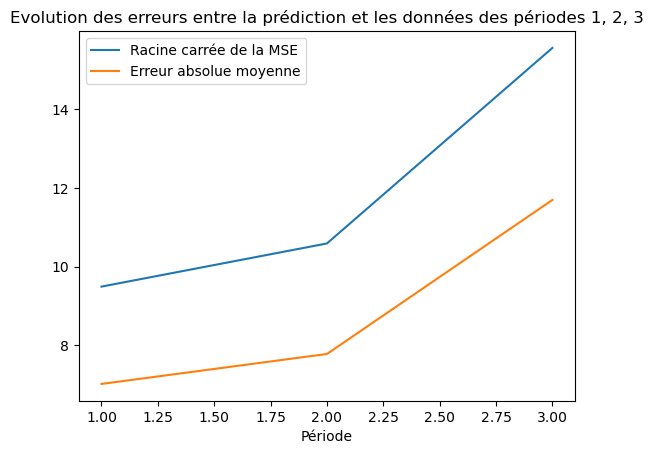

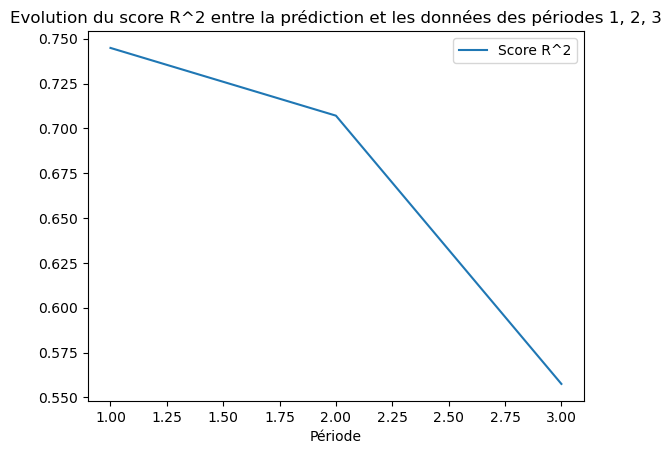

In [101]:
# Insérez votre code ici

alphas = np.logspace(0, 5, 100)
#On entraine le modèle sur toute la période 0
model_chosen = lm.RidgeCV(alphas=alphas, scoring='r2').fit(X, y)
rmse = []
mae = []
r_squared = []
for i in range(3):
    period_data  = pd.DataFrame(pd.read_csv("period_"+str(i+1)+".csv"))
    design = pd.get_dummies(data=period_data, drop_first=True).drop(columns="TotalCart", axis=1)
    response = period_data["TotalCart"]
    prediction = model_chosen.predict(design)
    rmse.append(sqrt(mean_squared_error(response, prediction)))
    mae.append(mean_absolute_error(response, prediction))
    r_squared.append(r2_score(response, prediction))
plt.plot(['1','2','3'], rmse)
plt.plot(['1','2','3'], mae)
plt.legend(["Racine carrée de la MSE", "Erreur absolue moyenne"])
plt.title("Evolution des erreurs entre la prédiction et les données des périodes 1, 2, 3")
plt.xlabel("Période")
plt.figure()
plt.plot(['1','2','3'], r_squared)
plt.legend(["Score R^2"])
plt.title("Evolution du score R^2 entre la prédiction et les données des périodes 1, 2, 3")
plt.xlabel("Période")


On choisit 3 métriques pour évaluer la qualité de la prédiction: RMSE (racine carrée de la Mean Squared Error):
$\text{MSE} = \mathbb{E}\lVert y-\hat{y} \rVert^2$,
MAE (erreur absolue moyenne): $\text{MAE} = \frac 1 n \sum_{i=1}^{n}|y-\hat{y}|$ et le score $R^2$ de régression
Le graphe de ces trois métriques indiquent que la qualité de la prédiction s'est dégradée dans le temps,
surtout à partir de la période 2, ce qui nous indique une potentielle dérive, comme on va le voir bientôt.

# Mesure de la dérive de variables catégorielles.

Pour deux distributions de probabilités discrètes $P$ et $Q$, la **divergence de Kullback–Leibler** de $P$ par rapport à $Q$ est définie par:

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$


On définit la **divergence de Jensen-Shannon** comme une version lisse et symétrique de la divergence de Kullback-Leiber donnée par la formule suivante:

$${\rm JSD}(P \parallel Q)= \frac{1}{2}D(P \parallel M)+\frac{1}{2}D(Q \parallel M)$$

où $M=\frac{1}{2}(P+Q)$

### Exemple de calcul de $D_\text{KL}(P \parallel Q)$ : 

Soient $P$ =`[0.2, 0.3, 0.5]` et $Q$ =`[0.2, 0.4, 0.4]` deux vecteurs définissant une loi de probabilité discrete. Alors : 

$$
\begin{equation}
\begin{split}
D_\text{KL}(P \parallel Q) & = P(0) \log\left(\frac{P(0)}{Q(0)}\right)
                             + P(1) \log\left(\frac{P(1)}{Q(1)}\right)
                             + P(2) \log\left(\frac{P(2)}{Q(2)}\right)\\ \\
                           & = 0.2 \log\left(\frac{0.2}{0.2}\right)
                             + 0.3 \log\left(\frac{0.3}{0.4}\right)
                             + 0.5 \log\left(\frac{0.5}{0.4}\right) \\ \\
                           & = 0.02526...
\end{split}
\end{equation}
$$

### Exercice

* Implémenter des fonctions nommées **`KLDivergence(P, Q)`** et **`JSDivergence(P, Q)`** permettant de calculer les métriques définies ci-dessus.

**Conseils**:
* Utiliser la librairie Numpy permettant de facilement effectuer des calculs d'algèbre linéaire.

In [117]:
import numpy as np 

P = np.array([0.2, 0.3, 0.5])
Q = np.array([0.2, 0.4, 0.4])

def KLDivergence(P, Q):

    # Insérez votre code ici
    return np.sum(P * np.log(P / Q))

def JSDivergence(P, Q):
    
    # Insérez votre code ici
    M = 0.5*(P + Q)
    return 0.5 * KLDivergence(P, M) + 0.5 * KLDivergence(Q, M)

* Lancer la cellule suivante pour tester votre fonction.

In [77]:
print("K-L Divergence:", KLDivergence(P, Q))
print("J-S Divergence:", JSDivergence(P, Q))

K-L Divergence: 0.02526715392157057
J-S Divergence: 0.006367198333995731


# Mesure de la dérive de variables quantitatives.

Soit $P$ une mesure empirique d'échantillons $X_1, \ldots, X_n
$ et $Q$ une mesure empirique d'échantillons $Y_1, \ldots, Y_n$, on définit la **Distance de Wasserstein** d'ordre $p$ par la fonction suivante :

$$W_p(P, Q) = \left( \frac{1}{n}\sum_{i=1}^n \|X_{(i)} - Y_{(i)}\|^p \right)^{1/p}$$

où $X_{(1)}, \ldots, X_{(n)}$ et $Y_{(1)}, \ldots, Y_{(n)}$ sont les [**statistiques d'ordre**](https://en.wikipedia.org/wiki/Order_statistic#Notation_and_examples) des échantillons $X$ et $Y$ et $p$ un nombre entier positif.

### Exercice

* Implémenter une fonction nommée **`WassersteinDistance(X, Y, p)`** permettant de calculer cette métrique à l'ordre **`p`** à partir de **deux échantillons** **`X`** et **`Y`** que l'on supposera de même longueur.

**Conseils**:
* Vous pouvez trier les échantillons pour obtenir les statistiques d'ordre.

In [134]:
def WassersteinDistance(X, Y, p):
    
    # Insérez votre code ici
    n = len(X)
    X_sort = np.sort(X)
    Y_sort = np.sort(Y)
    return (np.sum(np.abs(X_sort-Y_sort)**p)/n)**(1/p)    

* Lancer la cellule suivante pour tester votre fonction.

In [114]:
X = np.random.beta(2, 6, 100)

Y = np.random.beta(3, 6, 100)

WassersteinDistance(X, Y, 2)

0.07737795493848457

# Étude de la dérive du modèle.

* En vous appuyant sur les métriques définies précédemment, illustrez et analysez visuellement la **dérive des données** ainsi que **la dérive du modèle** sur les périodes **1 à 3**. 


* Commenter les visualisations et déterminer si le modèle doit être mis à jour ou si sa performance est toujours acceptable. 

**Conseils**:
* Vous serez évalué sur **la rigueur et le soin** que vous donnerez à votre analyse, et sur **vos capacités à synthéthiser votre étude**. Vous ne serez pas évalué sur vos conclusions.


* Vous pouvez normaliser les données par rapport aux **moyennes et variances que vous calculerez sur la période 0** pour que les distances de Wasserstein pour différentes variables soient facilement comparables.

'Toutes les métriques choisies indiquent que la dérive des covariables est minime entre les périodes 1, 2 et 3\n '

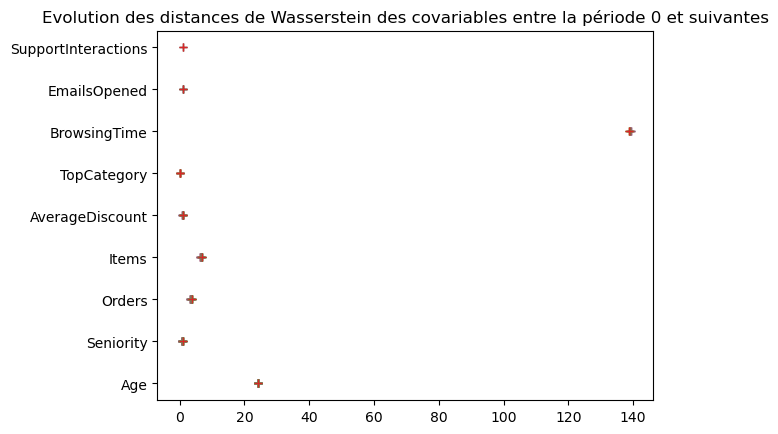

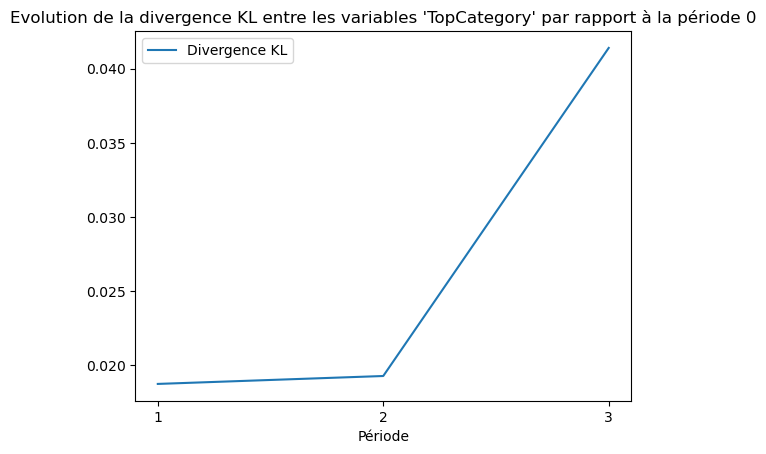

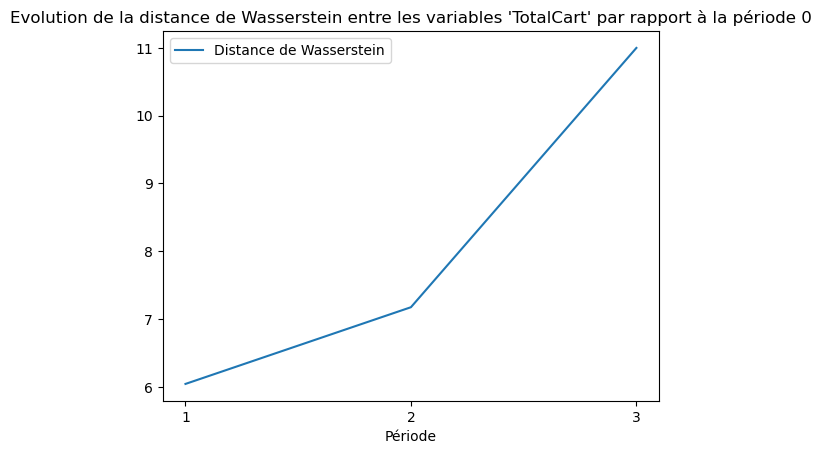

<Figure size 640x480 with 0 Axes>

In [251]:
# Insérez votre code ici

#distances: contient les distances entre les variables de la période i et celles de la période 0
distances = [dict.fromkeys(period_data.keys()) for i in range(3)]
#Probabilités sur la période 0 de chaque catégorie de "TopCategory"
freq_cat = pd.value_counts(df["TopCategory"])/len(df)
for i in range(3):
    period_data = pd.DataFrame(pd.read_csv("period_"+str(i+1)+".csv"))
    for variable in period_data.keys():
        if variable == "TotalCart":
            #Va mesurer la dérive du modèle
            distances[i]["TotalCart"] = WassersteinDistance(df["TotalCart"], period_data["TotalCart"], 1)
        elif variable == "TopCategory":
            #Calcul de la dérive de variable catégorielle
            #Probabilités sur la période i de chaque catégorie de "TopCategory"
            freq_cat_period = pd.value_counts(period_data["TopCategory"])/len(df)
            distances[i]["TopCategory"] = KLDivergence(freq_cat_period, freq_cat)
        else:
            #On normalise les covariables par rapport à la période 0
            normalized = (period_data[variable] - np.mean(df[variable]))/sqrt(np.var(df[variable]))
            distances[i][variable] = WassersteinDistance(df[variable], normalized, 2)
            plt.plot([distances[i][key] for key in df.keys()], df.keys(), "+")
plt.title("Evolution des distances de Wasserstein des covariables entre la période 0 et suivantes")
plt.figure()
plt.plot(['1', '2', '3'], [distances[i]["TopCategory"] for i in range(3)], label = "Divergence KL")
plt.xlabel("Période")
plt.title("Evolution de la divergence KL entre les variables 'TopCategory' par rapport à la période 0")
plt.legend()
plt.figure()
plt.plot(['1','2','3'], [distances[i]["TotalCart"] for i in range(3)], label = "Distance de Wasserstein")
plt.xlabel("Période")
plt.title("Evolution de la distance de Wasserstein entre les variables 'TotalCart' par rapport à la période 0")
plt.legend()
plt.figure()

### Conclusions:
Toutes les métriques choisies indiquent que la dérive des covariables est minime pour les périodes 1, 2 et 3.
Par contre, la variable réponse 'TotalCart' a fortement dévié, surtout entre les périodes 2 et 3.
Une telle dérive du modèle indique que la distribution de probabilité de la variable du total panier consommateur
a changé.  
Un tel changement peut par exemple s'expliquer par le fait que le quatrième trimestre contient la période
des fêtes, pendant laquelle les consommateurs tendent à achteter plus et des articles plus chers.
Il n'est donc pas judicieux d'utiliser le premier trimestre de 2022 pour prédire le montant du panier sur toute l'année.  
Il faudrait mettre à jour le modèle pour refléter cette tendance, i.e inclure une variable de saisonnalité
qui donnerait plus de poids aux valeurs élevées de panier lors du S4, pour refléter cette tendance.
